# Generating Dog Images with GAN

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd /content/drive/My Drive/Datasets/Traffic Sign Images


Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import os 
import cv2 
import time
import pickle
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET 
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization,LeakyReLU, Reshape, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


## Loading Data

In [4]:
# reading features and the labels
def read_file(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    X = data['features']
    y = data['labels']
    return X,y

In [5]:
img_arr, labels=read_file('../input/train/train.p')

In [6]:
m = len(img_arr)
img_size = 32

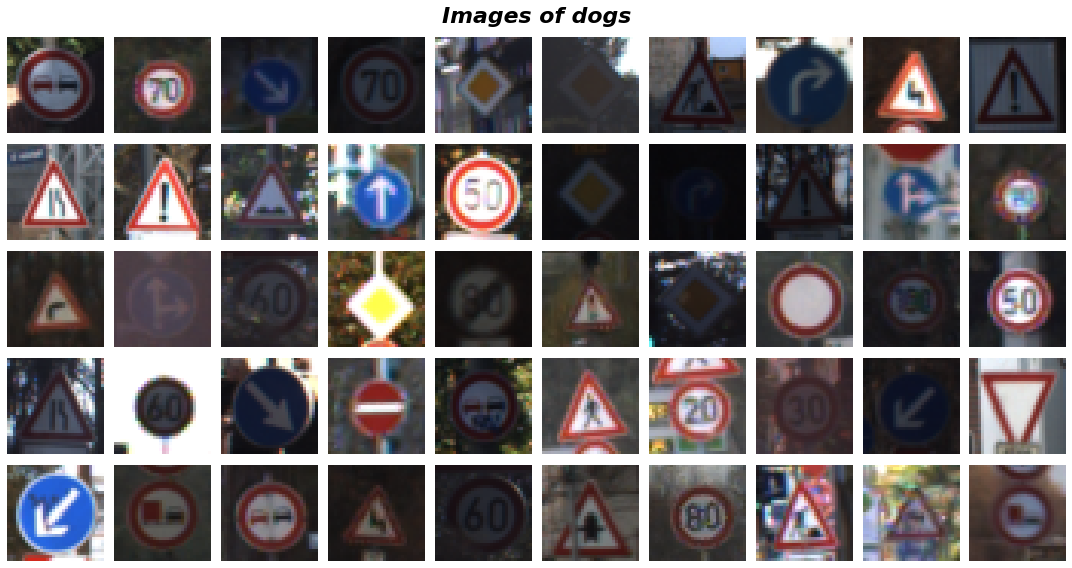

In [8]:
# visualizing the images of dogs

plt.figure(figsize=(15,8))
plt.suptitle('Images of Traffic Signs', fontsize=22, 
             fontweight='bold', fontstyle='italic')

for i in range(50):
    plt.subplot(5,10,i+1)
    ind_ = np.random.randint(0,m)
    plt.imshow(img_arr[ind_])
    plt.axis('off')
    plt.tight_layout()

Since it is recommended to use hyperbolic tangent activation function as the output from the generator model, we'll have to normalize the pixel values of the image, i.e scale images to the range [-1,1]

In [9]:
norm_img = (img_arr-127.5)/127.5

In [10]:
# gradient functions from TF require float32 instead of float64
img_tensors = tf.cast(norm_img, 'float32')

2022-02-01 05:55:54.906379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 05:55:55.021111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 05:55:55.021825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 05:55:55.024464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
buffer = 20000
batch_size = 32

data = tf.data.Dataset.from_tensor_slices(img_tensors).shuffle(buffer).batch(batch_size)

## Define GAN

Generative adversarial networks is made up of two models: a generative model and a discriminative model.
    
The discriminator model is a classifier that determines whether a given image resembles a real image from the dataset or an image that was created artificially. This is essentially a binary classifier.
The generator model uses a deconvolutional neural network to transform random input values into images.

Backpropagation is used to train the discriminator and generator's weights and biases over a large number of iterations. The discriminator learns to differentiate between "real" and "false" images generated by the generator. Simultaneously, the generator learns from the discriminator's feedback how to create convincing images that the discriminator is unable to distinguish from genuine ones.

#### Initializing weights
Before training the GAN, the model parameters must be initialized to some random values. I will  initialize all parameters using a zero-centered Gaussian distribution with a standard deviation of 0.02.

In [12]:
# weight initializers for the generator network
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

### Generator
Generator is a reverse CNN. It takes a d-dimensional noise vector and upsamples it to a 32 x 32 x 3 image. To stabilise the outputs of each layer, leaky ReLU and batch normalisation are used.

In [13]:
def define_generator():
    
    model = Sequential()
    model.add(Dense(4*4*256, use_bias=False, input_shape=(100,) ))
    # Batch normalization will have the activations from the prior layer zero mean and unit variance.
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((4,4,256)))
    
    f = [128,64,32]
    for filter_ in f:
        model.add(Conv2DTranspose(filters=filter_, kernel_size=(5,5), strides=(2,2), padding='same',
                                 use_bias=False, kernel_initializer=initializer))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
    
    model.add(Dense(3, activation='tanh', use_bias=False, kernel_initializer=initializer))
    return model
        
                  

In [14]:
# create an instance of the generator model defined
generator = define_generator()
print(generator.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

2022-02-01 05:56:00.229430: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(1, 32, 32, 3)


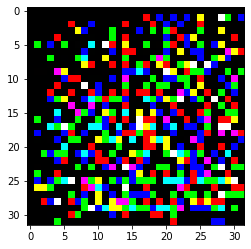

In [15]:
noise = tf.random.normal([1,100])

# run the generator model with the noise vector as input
generated_image = generator(noise, training=False)
# display output
plt.imshow(generated_image[0].numpy().astype('uint8'))
print(generated_image.shape)

### Discriminator
Discriminator is a CNN that takes an image of size 32 x 32 x 3 as input and returns a output indicating whether the image is "real" or "fake".

In [16]:
def define_discriminator():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(4,4), strides=(2,2),
                     padding='same', input_shape=[img_size,img_size,3], kernel_initializer=initializer))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    f = [128,256]
    for filter_ in f:
        model.add(Conv2D(filters=filter_, kernel_size=(4,4), strides=(2,2),
                 padding='same', kernel_initializer=initializer))

        model.add(BatchNormalization())
        model.add(LeakyReLU())
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model


In [17]:
# create an instance of the discriminator model defined
discriminator = define_discriminator()
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        1568      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         65664     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

In [18]:
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.30849847]], shape=(1, 1), dtype=float32)


#### Label smoothing



In [19]:
def smooth_posY(y):
    '''uniformly smoothing the positive label values into the range [0.7, 1.0]'''
    
    np.random.seed(0)
    return y - 0.3 + (np.random.random(y.shape) * 0.3)


def smooth_negY(y):
    '''uniformly smoothing the negative label values into the range [0.0, 0.5]'''
    
    np.random.seed(0)
    return y + (np.random.random(y.shape) * 0.5)

#### Adding noise to labels
Introducing errors to some labels at random, so that some fake images are marked as real and some real images are marked as fake

In [20]:
def add_noise(y, prob):
    
    # determine the number of labels to add noise to.
    n = int(prob * y.shape[0])
    
    # randomly getting n indices to add noise
    np.random.seed(0)
    noise_idx = np.random.choice(y.shape[0], size=n)
    
    # adding noise
    y[noise_idx] = 1 - y[noise_idx]
    return y

#### Loss Function

In [21]:

# a helper function for calculating cross-entropy loss

cost = BinaryCrossentropy(from_logits=False)


def discriminator_loss(real_pred, fake_pred):
    
    real_orig = tf.ones_like((real_pred))
    real_orig = smooth_posY(real_orig) 
    real_loss = cost(real_orig, real_pred)
    
    fake_orig = tf.zeros_like((fake_pred))
    fake_orig = smooth_negY(fake_orig)
    fake_loss = cost(fake_orig, fake_pred)
    
    return real_loss+fake_loss


def generator_loss(fake_pred):
    
    fake_orig = tf.ones_like((fake_pred))
    fake_orig = smooth_negY(fake_orig)
    return cost(fake_orig, fake_pred)



## Training the GAN

In [22]:

def optimizer():
    ''' helper function for adam optimizer '''
  
    return Adam(learning_rate=0.0002, beta_1=0.5)


def apply_grads(model, tape, opt, loss):
        
    '''The derivatives are calculated and gradients are applied 
    using the Adam optimizer in the following lines of code.'''
    
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

In [23]:
generator = define_generator()
discriminator = define_discriminator()

gen_optimizer = optimizer()
disc_optimizer = optimizer()

In [24]:
def train_batch(img_batch, gen_loss_list, disc_loss_list):
    
    # generate noise of 100 dimensions
    noise = tf.random.normal([batch_size, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_img = generator(noise, training=True)
        
        real_pred = discriminator(img_batch, training=True)
        fake_pred = discriminator(gen_img, training=True)
        
        disc_loss = discriminator_loss(real_pred, fake_pred)
        gen_loss = generator_loss(fake_pred)
        
    gen_loss_list.append(gen_loss.numpy())
    disc_loss_list.append(disc_loss.numpy())

    
    apply_grads(generator, gen_tape, gen_optimizer, gen_loss)
    apply_grads(discriminator, disc_tape, disc_optimizer, disc_loss)


In [25]:

def plot_loss(gloss, dloss, epoch):
    
    '''plot loss for both generator and discriminator'''
    plt.figure(figsize=(12,5))
    plt.title(f'Generator and Discriminator loss for epoch# {epoch}')
    plt.plot(gloss, label='Generator Loss')
    plt.plot(dloss, label='Discriminator Loss') 
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()
    
def generate_images(n_test, gen_model):
    
    '''Generate 12 images to validate the generator's performance.'''
    test_input = tf.random.normal([n_test,100])
    img_preds = gen_model(test_input, training=False)
    plt.figure(figsize=(12,6))
    for i in range(n_test):
        plt.subplot(4,3,i+1)
        img = (img_preds[i].numpy()*127.5)+127.5
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
    plt.show()  

In [26]:
# with strategy.scope():

def train_GAN(data, epochs):
    gen_loss_list = []
    disc_loss_list = []

    for epoch in range(epochs):
        start = time.time()

        for img_batch in data:
            train_batch(img_batch, gen_loss_list, disc_loss_list)
            
        g_loss = sum(gen_loss_list)/len(gen_loss_list)
        d_loss = sum(disc_loss_list)/len(disc_loss_list)
        print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss}')

        if epoch % 1 == 0:
            
            plot_loss(gen_loss_list, disc_loss_list, epoch)
            generate_images(12, generator)
        
        end = time.time()
        total = end-start
        print (f'Time for epoch# {epoch} is {total} sec.')

        gen_loss_list = []
        disc_loss_list = []    


Epoch 1, gen loss = 1.4835202869794823, disc loss = 1.0363865064128357


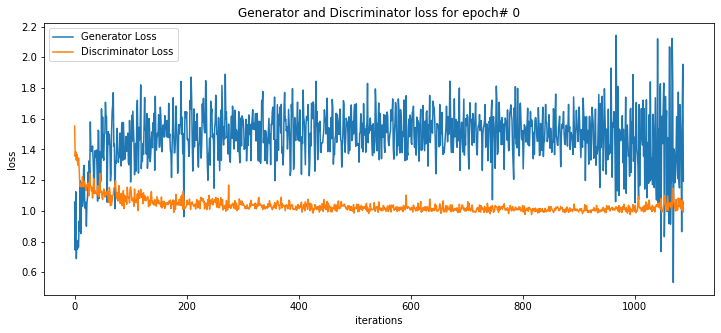

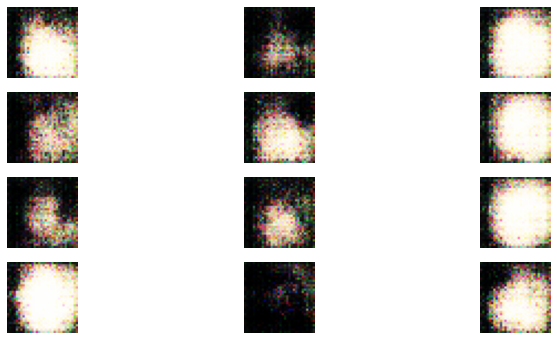

Time for epoch# 0 is 63.33908009529114 sec.
Epoch 2, gen loss = 1.3569224801133661, disc loss = 1.0371087610392886


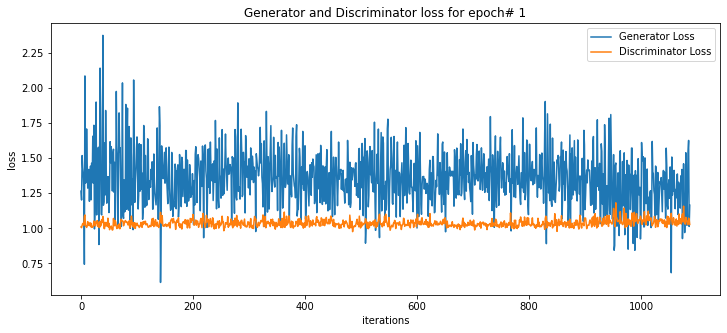

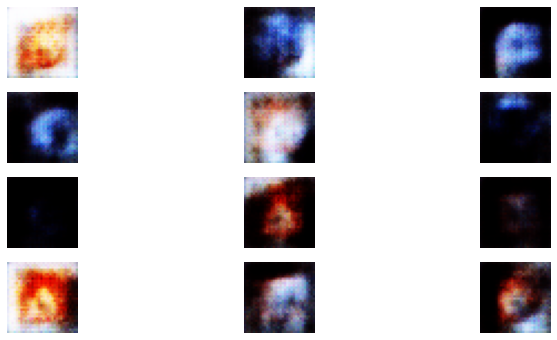

Time for epoch# 1 is 63.60593366622925 sec.
Epoch 3, gen loss = 1.3133923627217026, disc loss = 1.0494573862456225


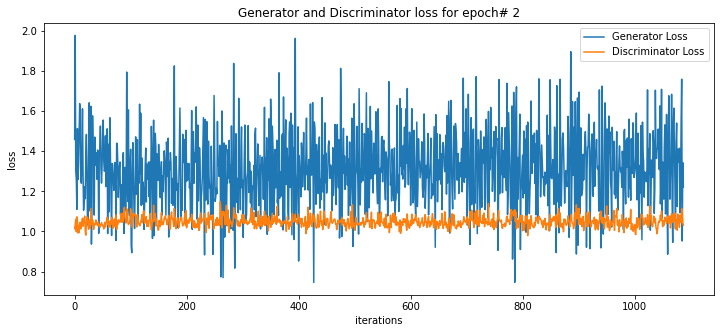

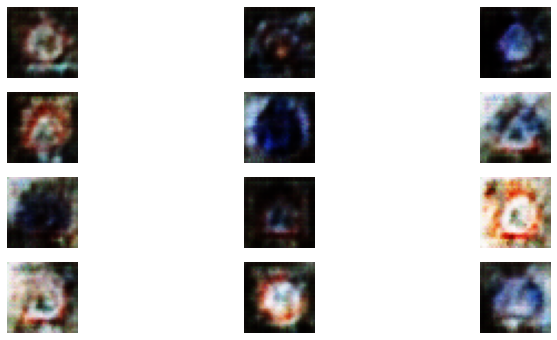

Time for epoch# 2 is 82.99162912368774 sec.
Epoch 4, gen loss = 1.3293889554436593, disc loss = 1.0502310577122604


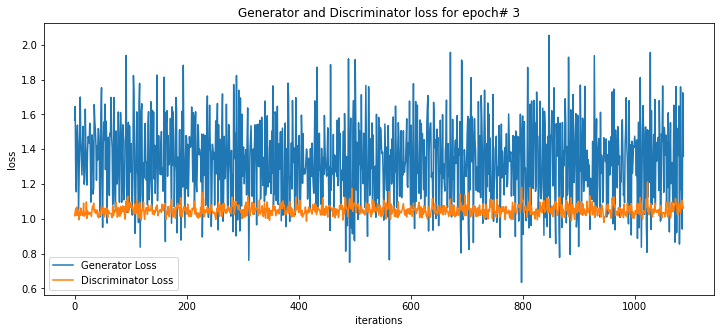

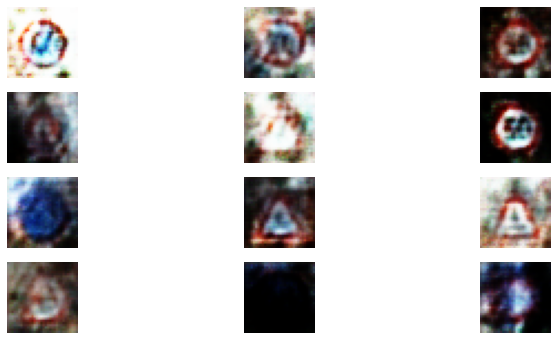

Time for epoch# 3 is 63.53546667098999 sec.
Epoch 5, gen loss = 1.3546051302486484, disc loss = 1.045545097111779


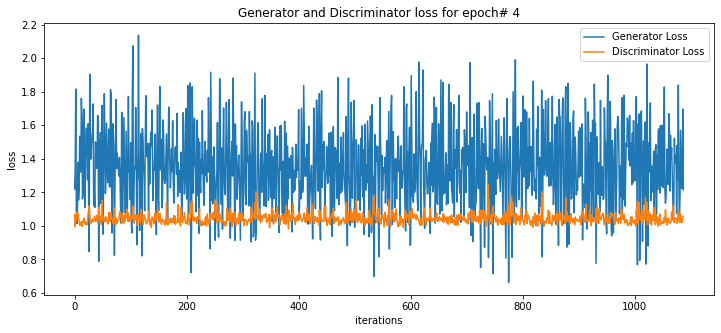

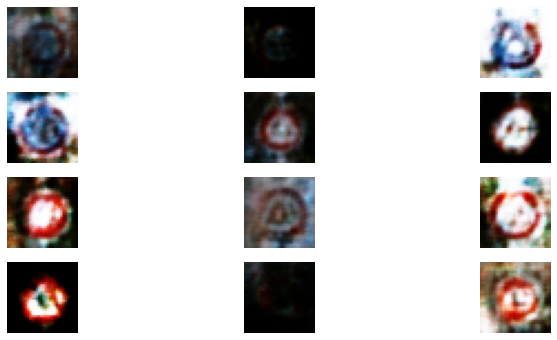

Time for epoch# 4 is 63.820502519607544 sec.


In [27]:

train_GAN(data,5)

In [ ]:
generate_images(12, generator)
